In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax
import argparse
import sys
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from utils import *

In [2]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

# Load data

In [3]:
data_path = "/cluster/tufts/pettilab/shared/structure_comparison_data"

In [4]:
two= True

In [5]:
pairs_path = f"{data_path}/train_test_val/pairs_validation.csv"
coord_path = f"{data_path}/alphabets_blosum_coordinates/allCACoord.npz"
oh1_path = f"{data_path}/alphabets_blosum_coordinates_OLD/mse_fasta.npz"
blosum1_path = f"{data_path}/alphabets_blosum_coordinates_OLD/mse_mat.npy"
lddts_given_path = f"{data_path}/train_test_val/pairs_validation_lddts.csv"
if two:
    oh2_path = f"{data_path}/alphabets_blosum_coordinates_OLD/3Di_oh_POSTFIX.npz"
    blosum2_path = f"{data_path}/alphabets_blosum_coordinates_OLD/mat3di.npy"
    #oh2_path = f"{data_path}/alphabets_blosum_coordinates/mse_fasta.npz"
    #blosum2_path = f"{data_path}/alphabets_blosum_coordinates/mse_mat.npy"

## check that databases have same keys and same length sequences

In [6]:
#hot_d; protien_name: L by alphabet size or num bins + 1; encode sequence in alphabet or nhots
#coord_d; protein_name: L by 3; encodes 3D coordinates

In [7]:
coord_d = np.load(coord_path)
oh_d1 = np.load(oh1_path)
blosum1 = np.load(blosum1_path)[:-1,:-1].astype(float)
if two:
    oh_d2 = np.load(oh2_path)
    blosum2 = np.load(blosum2_path)[:-1,:-1].astype(float)
    

In [8]:
# MANUAL ADJUSTMENT OF 3Di BLOSUM 
arr = blosum2
zeros_row = jnp.zeros((1, arr.shape[1]))
arr_with_row = jnp.vstack([arr, zeros_row])

# Add a column of zeros on the right
zeros_col = jnp.zeros((arr_with_row.shape[0], 1))
arr_with_row_and_col = jnp.hstack([arr_with_row, zeros_col])
blosum2 = arr_with_row_and_col

In [9]:
# check sizes of alphabets
if oh_d1[list(oh_d1.keys())[0]].shape[1]!=blosum1.shape[1]:
        raise ValueError(f"one-hot encoding length does not match blosum shape {blosum.shape[1]}")
if two:  
    if oh_d2[list(oh_d2.keys())[0]].shape[1]!=blosum2.shape[1]:
        raise ValueError(f"one-hot encoding length does not match blosum2 shape {blosum2.shape[1]}")

In [10]:
# check overlap of keys and sequence lengths
bad_list1 = check_keys_and_lengths(oh_d1, coord_d)
print(bad_list1)
if two:
    bad_list2 = check_keys_and_lengths(oh_d2, coord_d)
    print(bad_list2)
    bad_list = bad_list1 + bad_list2
print(len(bad_list))

all keys match
[]
in hot_d but not coord_d:
{'d1n13', 'd1qrj', 'd1bom', 'd1dy9', 'd1apy', 'd1y43', 'd1bi6', 'd1mso', 'd1avo', 'd2vt1', 'd1jjo', 'd1htr', 'd1wht', 'd1k2x', 'd1w2w', 'd1qd6', 'd1ugx', 'd1mhm', 'd3n55', 'd1k3b', 'd1mtp', 'd1kve', 'd1pya', 'd1m93', 'd6rlx', 'd1or0', 'd2mev', 'd1xew', 'd1jmu', 'd1o7d', 'd1qtn', 'd3bzy', 'd1h8d', 'd1ko6', 'd1gk9', 'd1f8v', 'd1pyo', 'd1pnb', 'd1aym', 'd1b35', 'd1dnu', 'd1dgw', 'd1r8o', 'd1q7l', 'd1qqp', 'd1sc3', 'd1sse', 'd1f2t', 'd2dg5'}
in coord_d but not hot_d:
{'d1mhm.1', 'd3bzy.1', 'd1ugx.1', 'd1w2w.1', 'd1ko6.1', 'd1jmu.1', 'd1xew.1', 'd1avo.1', 'd1dnu.1', 'd1y43.1', 'd1aym.1', 'd6rlx.1', 'd1o7d.2', 'd1m93.1', 'd1pyo.1', 'd1mtp.1', 'd1b35.1', 'd1jjo.1', 'd1sse.1', 'd1pya.1', 'd2vt1.1', 'd1bi6.2', 'd1apy.1', 'd1f8v.1', 'd1qrj.1', 'd1pnb.1', 'd1r8o.1', 'd1q7l.1', 'd1gk9.1', 'd1dy9.1', 'd1n13.1', 'd1o7d.1', 'd1mso.1', 'd2mev.1', 'd1h8d.1', 'd1dgw.1', 'd1o7d.3', 'd1kve.1', 'd1k2x.1', 'd1qqp.1', 'd1bom.1', 'd1or0.1', 'd2dg5.1', 'd1htr.1', 'd1

## load in validation pairs, lddt of given aln, and their TMscores

In [14]:
# remove anything with 'd1e25a_' since we seem to be having some length issues
# remove any pairs with length > 512 
bad_list.append('d1e25a_')
pairs = []
alns_as_lists = []
first = True
tm_d = {}
n2l_d = make_name_to_length_d(oh_d1)
with open(pairs_path, mode='r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        pair = (row[1],row[2])
        if first:
            first = False
            continue    
        elif pair[0] in bad_list or pair[1] in bad_list:
            continue
        elif n2l_d[pair[0]]>512 or n2l_d[pair[1]]>512:
            continue
        else:
            pairs.append(pair)
            tm_d[pair]= float(row[3])
            alns_as_lists.append([int(i) for i in row[-1].strip('[]').split()])
print(len(pairs))

2828


In [15]:
# load lddt given by alignments in validation_pairs.csv 
# computed in /cluster/tufts/pettilab/spetti04/structure_comparison/benchmarking/lddt_for_precomputed_alns.ipynb

given_lddt_d = {}

# Open the CSV file for reading
with open(lddts_given_path, mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        a, b, value = row[0], row[1], float(row[2])  # Convert value to float
        given_lddt_d[(a, b)] = value

print(len(given_lddt_d.keys()))

check_keys(given_lddt_d, tm_d)

2828
all keys match


[]

## Sort for better batching

In [16]:
# sort pairs by length of longer protein
pair_max_length_pairs = [(pair, max(n2l_d[pair[0]], n2l_d[pair[1]])) for pair in pairs]
sorted_keys = sorted(pair_max_length_pairs, key=lambda x: x[1])
sorted_pairs = [key for key, shape in sorted_keys]
pairs = sorted_pairs

In [17]:
# get lists of given lddt and tm score in the order that we will get our results
given_lddt_list = [given_lddt_d[p] for p in pairs]
tm_list = [tm_d[p] for p in pairs]

## Plot lddt vs TM score for given alignments

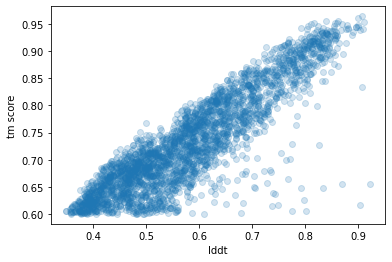

In [18]:
plt.scatter(given_lddt_list, tm_list, alpha = .2)
plt.xlabel("lddt")
plt.ylabel("tm score")
plt.show()

# Run alignment benchmark

In [23]:
def run_in_batches(long_list, batch_size, params, data):
    result = []
    for i in range(0, len(long_list), batch_size):
        batch = long_list[i:i + batch_size]  # Get the current batch
        result.extend(run_batch(batch, params, data))   # Process and extend results
        print(f"finished batch {i}")
    return result

def run_batch(pairs, params, data):

    oh_d= data["oh_d"]
    blosum = data["blosum"]
    if params["use_two"]:
        oh_d2 = data["oh_d2"]
        blosum2 = data["blosum2"]

    # compute max length of any protein
    names=[item for tup in pairs for item in tup]
    max_len = max([n2l_d[name] for name in names])
    pad_to = int(jnp.where(max_len < 1, 1, 2 ** jnp.ceil(jnp.log2(max_len))))
    #print(pad_to)

    #print(max([oh_d[pair[0]].shape[0] for pair in pairs]))
    # get oh and coords for left and right part of pairs, padded
    lefts, left_lengths = pad_and_stack_manual([oh_d[pair[0]] for pair in pairs],pad_to = pad_to)
    rights, right_lengths = pad_and_stack_manual([oh_d[pair[1]] for pair in pairs], pad_to = pad_to)
    
    if params["use_two"]:
        lefts2, _ = pad_and_stack_manual([oh_d2[pair[0]] for pair in pairs],pad_to = pad_to)
        rights2, _ = pad_and_stack_manual([oh_d2[pair[1]] for pair in pairs], pad_to = pad_to)

    left_coords, _ = pad_and_stack_manual([coord_d[pair[0]] for pair in pairs],pad_to = pad_to)
    right_coords, _ = pad_and_stack_manual([coord_d[pair[1]] for pair in pairs], pad_to = pad_to)

    # make similarity matrices
    sim_tensor = vv_sim_mtx(lefts, rights, blosum)
    if params["use_two"]:
        sim_tensor *= params["w1"]
        sim_tensor += params["w2"]*vv_sim_mtx(lefts2, rights2, blosum2)

    # align (gap, open, temp)
    length_pairs = jnp.column_stack([left_lengths, right_lengths])
    aln_tensor = v_aln_w_sw(sim_tensor, length_pairs, params["gap_extend"], params["gap_open"],params["temp"])

    # compute lddts 
    lddts = vv_lddt(left_coords, right_coords, aln_tensor, jnp.sum((aln_tensor>0.95).astype(int), axis = [-2,-1]), jnp.array(left_lengths))

    return lddts

## Test (unnecesary, but gives idea of timing)

In [19]:
params = {}
params["gap_extend"] = -1.0
params["gap_open"] = -10.0
params["temp"] = 0.01
params["use_two"]= False
params["w1"] =0.5
params["w2"] =0.5

In [20]:
data = {}
data["blosum"] = blosum1
data["oh_d"] = oh_d1

In [21]:
%%time
# faster with batch size 200 if you have sufficient memory for it
lddts=run_in_batches(pairs, 200, params, data)

256
137
finished batch 0
256
155
finished batch 200
256
166
finished batch 400
256
175
finished batch 600
256
207
finished batch 800
512
263
finished batch 1000
512
299
finished batch 1200
512
309
finished batch 1400
512
324
finished batch 1600
512
351
finished batch 1800
512
377
finished batch 2000
512
416
finished batch 2200
512
454
finished batch 2400
512
509
finished batch 2600
512
510
finished batch 2800
CPU times: user 27.9 s, sys: 2.53 s, total: 30.5 s
Wall time: 38.8 s


In [22]:
%%time
# faster with batch size 200 if you have sufficient memory for it
lddts=run_in_batches(pairs, 200, params, data)

256
137
finished batch 0
256
155
finished batch 200
256
166
finished batch 400
256
175
finished batch 600
256
207
finished batch 800
512
263
finished batch 1000
512
299
finished batch 1200
512
309
finished batch 1400
512
324
finished batch 1600
512
351
finished batch 1800
512
377
finished batch 2000
512
416
finished batch 2200
512
454
finished batch 2400
512
509
finished batch 2600
512
510
finished batch 2800
CPU times: user 7.83 s, sys: 1.66 s, total: 9.5 s
Wall time: 8.48 s


## Mini-grid search 

In [24]:
def plot(lddt_d, mode = "mean"):# Example dictionary (replace this with your actual data)
    data_dict = lddt_d

    # Get all unique x (o) and y (e) values
    x_values = sorted(set(o for o, e in data_dict.keys()))
    y_values = sorted(set(e for o, e in data_dict.keys()))

    # Create an empty 2D array to store the median values
    grid = np.zeros((len(y_values), len(x_values)))

    # Fill the grid with the median of the lists
   
    for (o, e), values in data_dict.items():
        if mode == "mean":
            val = np.mean(values)
        elif mode == "spearman_lddt":
            val =  ss.spearmanr(values, given_lddt_list).correlation
        elif mode == "spearman_tm":
            val =  ss.spearmanr(values, tm_list).correlation
        x_idx = x_values.index(o)
        y_idx = y_values.index(e)
        grid[y_idx, x_idx] = val
    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(grid, xticklabels=x_values, yticklabels=y_values, cmap='Blues', annot=True)

    # Add labels and title
    plt.xlabel('o values (x-axis)')
    plt.ylabel('e values (y-axis)')
    plt.title(f'{mode} heatmap')

    # Show the plot
    plt.show()

In [25]:
open_choices = [-20.0, -15.0,-10.0,-5.0, -1.0]
extend_choices =[0.0, -1.0,-2.0,-3.0]

### Just n-hot

In [26]:
%%time
lddt_d = {}
#open_choices = [-15.0,-10.0,-5.0, -1.0]
#extend_choices =[-1.0,-2.0,-3.0]

params = {}
params["temp"] = 0.01
params["use_two"]= False
params["w1"] =0.0
params["w2"] =0.0

data = {}
data["blosum"] = blosum1
data["oh_d"] = oh_d1

for o in open_choices:
    for e in extend_choices:
        params["gap_extend"] = e
        params["gap_open"] = o
        lddt_d[(o,e)] = run_in_batches(pairs, 200, params, data)


finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished

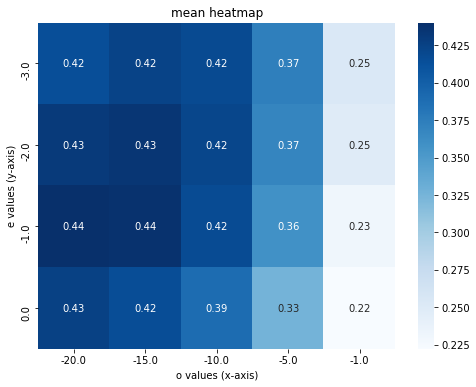

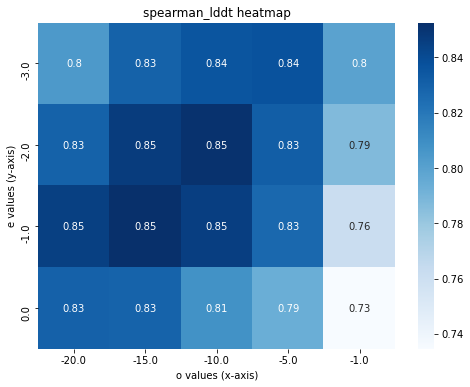

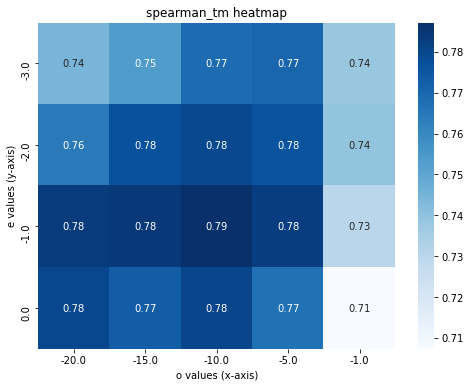

In [27]:
plot(lddt_d, mode = "mean")
plot(lddt_d, mode = "spearman_lddt")
plot(lddt_d, mode = "spearman_tm")

In [28]:
lddt_nh = lddt_d

## Just 3Di 

In [35]:
%%time
lddt_d = {}
#open_choices = [-15.0,-10.0,-5.0, -1.0]
#extend_choices =[-1.0,-2.0,-3.0]

params = {}
params["temp"] = 0.01
params["use_two"]= False
params["w1"] =0.0
params["w2"] =0.0

data = {}
data["blosum"] = blosum2
data["oh_d"] = oh_d2

for o in open_choices:
    for e in extend_choices:
        params["gap_extend"] = e
        params["gap_open"] = o
        lddt_d[(o,e)] = run_in_batches(pairs, 200, params, data)

finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished

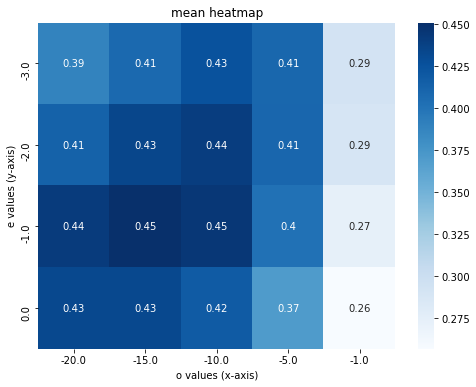

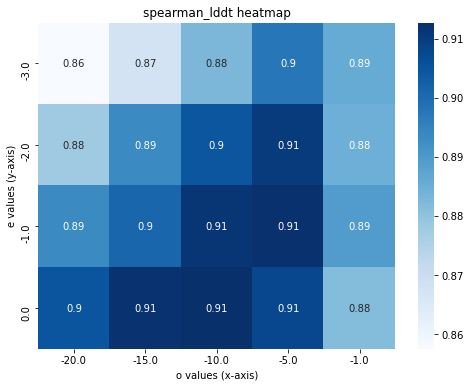

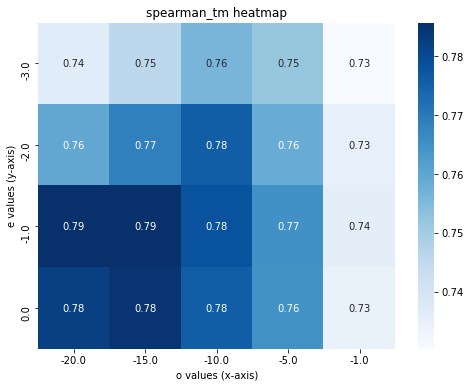

In [36]:
plot(lddt_d, mode = "mean")
plot(lddt_d, mode = "spearman_lddt")
plot(lddt_d, mode = "spearman_tm")

In [ ]:
lddt_mse = lddt_d

### mse and 3di  with equal weights 

In [37]:
%%time
lddt_d = {}
#open_choices = [-15.0,-10.0,-5.0, -1.0]
#extend_choices =[-1.0,-2.0,-3.0]

params = {}
params["temp"] = 0.01
params["use_two"]= True
params["w1"] = 0.5
params["w2"] = 0.5

data = {}
data["blosum"] = blosum1
data["oh_d"] = oh_d1
data["blosum2"] = blosum2
data["oh_d2"] = oh_d2


for o in open_choices:
    for e in extend_choices:
        params["gap_extend"] = e
        params["gap_open"] = o
        lddt_d[(o,e)] = run_in_batches(pairs, 200, params, data)

finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished

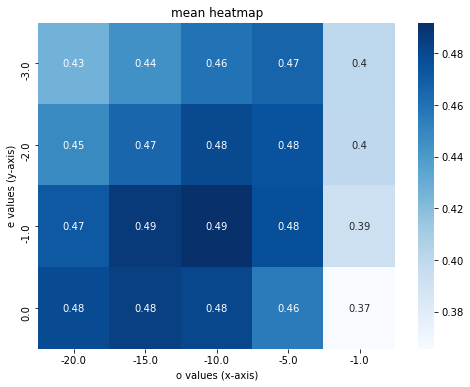

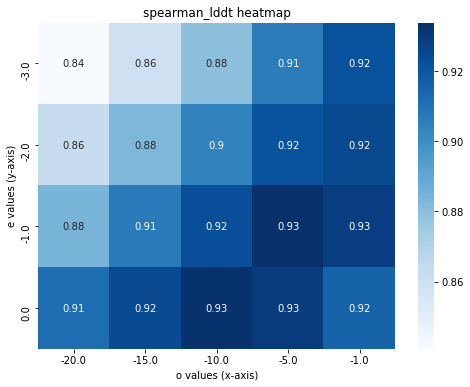

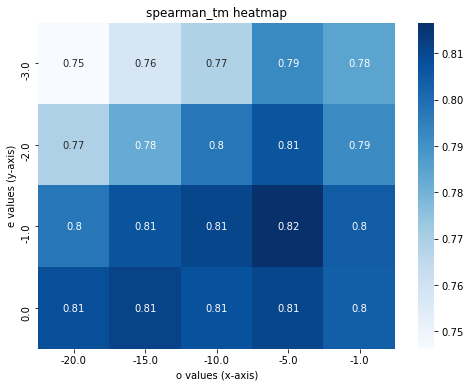

In [38]:
plot(lddt_d, mode = "mean")
plot(lddt_d, mode = "spearman_lddt")
plot(lddt_d, mode = "spearman_tm")

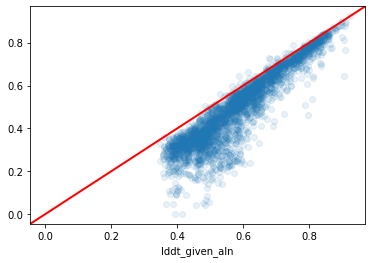

In [40]:
plt.scatter(given_lddt_list, lddt_d[( -15.0, -1.0)], alpha = .1)
plt.xlabel("lddt_us")
plt.xlabel("lddt_given_aln")
plt.axline((0, 0), slope=1, color='red', linewidth=2)

In [ ]:
lddt_equal_mix = lddt_d

### mse and 3di with uneven weights 

In [41]:
%%time
lddt_d = {}
#open_choices = [-15.0,-10.0,-5.0, -1.0]
#extend_choices =[-1.0,-2.0,-3.0]

params = {}
params["temp"] = 0.01
params["use_two"]= True
params["w1"] =0.3
params["w2"] = 0.7

data = {}
data["blosum"] = blosum1
data["oh_d"] = oh_d1
data["blosum2"] = blosum2
data["oh_d2"] = oh_d2


for o in open_choices:
    for e in extend_choices:
        params["gap_extend"] = e
        params["gap_open"] = o
        lddt_d[(o,e)] = run_in_batches(pairs, 200, params, data)

finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished

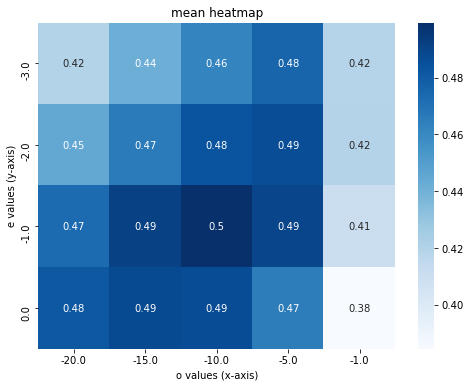

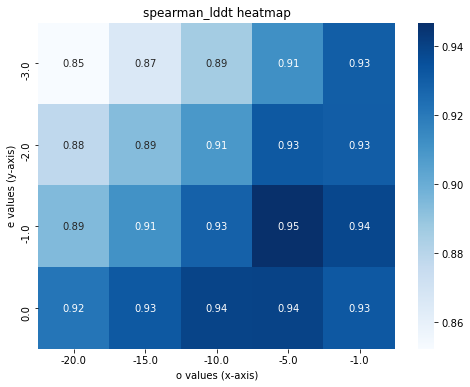

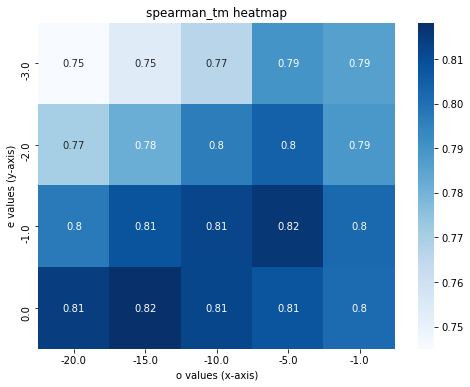

In [42]:
plot(lddt_d, mode = "mean")
plot(lddt_d, mode = "spearman_lddt")
plot(lddt_d, mode = "spearman_tm")

In [44]:
def scatter_lddts(lddt_d, key):
    plt.scatter(given_lddt_list, lddt_d[( -15.0, -1.0)], alpha = .1)
    plt.xlabel("lddt_us")
    plt.xlabel("lddt_given_aln")
    plt.axline((0, 0), slope=1, color='red', linewidth=2)
    plt.show()

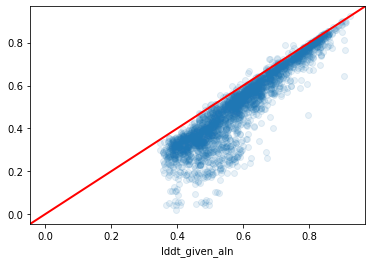

In [45]:
scatter_lddts(lddt_d, (-15.0,-1.0))

## unequal weights, finer grid

In [50]:
%%time
lddt_d = {}
open_choices = np.arange(-10,-4,1)
extend_choices =[-0.5,-1.0,-1.5]

params = {}
params["temp"] = 0.01
params["use_two"]= True
params["w1"] =0.3
params["w2"] = 0.7

data = {}
data["blosum"] = blosum1
data["oh_d"] = oh_d1
data["blosum2"] = blosum2
data["oh_d2"] = oh_d2


for o in open_choices:
    for e in extend_choices:
        params["gap_extend"] = e
        params["gap_open"] = o
        lddt_d[(o,e)] = run_in_batches(pairs, 200, params, data)

finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished

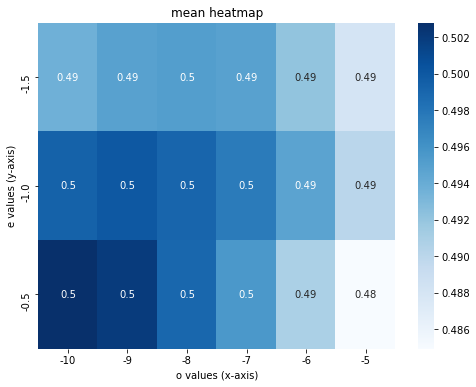

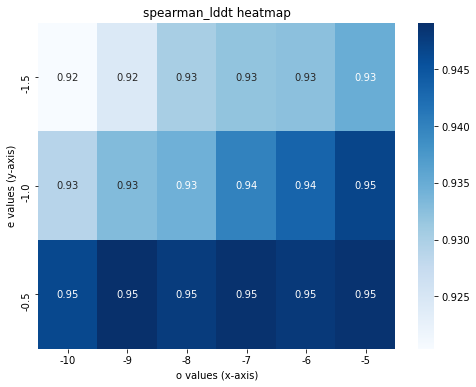

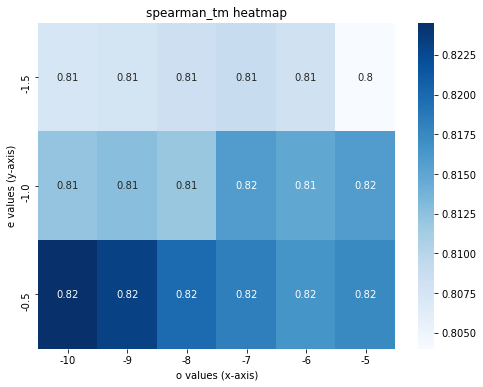

In [52]:
plot(lddt_d, mode = "mean")
plot(lddt_d, mode = "spearman_lddt")
plot(lddt_d, mode = "spearman_tm")

## equal weights finer grid

In [53]:
%%time
lddt_d = {}
open_choices = np.arange(-10,-4,1)
extend_choices =[-0.5,-1.0,-1.5]

params = {}
params["temp"] = 0.01
params["use_two"]= True
params["w1"] =0.5
params["w2"] = 0.5

data = {}
data["blosum"] = blosum1
data["oh_d"] = oh_d1
data["blosum2"] = blosum2
data["oh_d2"] = oh_d2


for o in open_choices:
    for e in extend_choices:
        params["gap_extend"] = e
        params["gap_open"] = o
        lddt_d[(o,e)] = run_in_batches(pairs, 200, params, data)

finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished

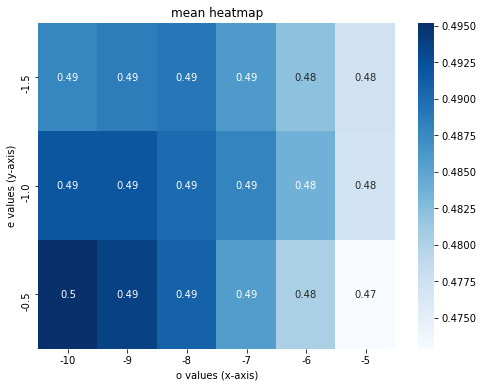

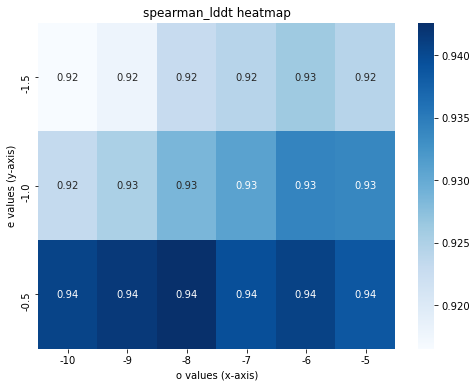

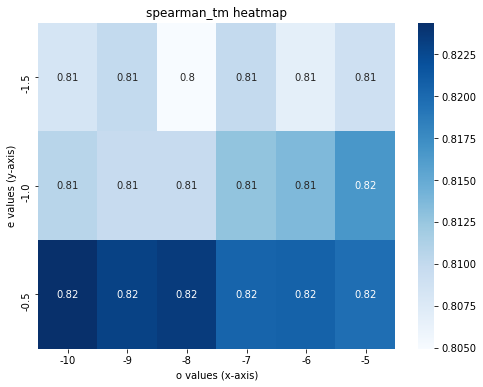

In [54]:
plot(lddt_d, mode = "mean")
plot(lddt_d, mode = "spearman_lddt")
plot(lddt_d, mode = "spearman_tm")